## Step 0: 셋업과 데이터 로드

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_ipospac = pd.read_csv("C:\\Users\\parkm\\Downloads\\IPOSPAC.csv")  
df_ipotransfer = pd.read_csv("C:\\Users\\parkm\\Downloads\\IPOTransfer.csv")

# TYPE 열 정규화 (공백 제거, 소문자 통일)
df_ipospac['TYPE'] = df_ipospac['TYPE'].str.strip().str.lower()
df_ipotransfer['TYPE'] = df_ipotransfer['TYPE'].str.strip().str.lower()

print("IPOSPAC.csv head:")
print(df_ipospac.head())
print("\nIPOTransfer.csv head:")
print(df_ipotransfer.head())

IPOSPAC.csv head:
  TYPE    RATIO
0  ipo  0.19985
1  ipo  0.25190
2  ipo  0.16834
3  ipo  0.13693
4  ipo  0.11368

IPOTransfer.csv head:
  TYPE    RATIO
0  new  0.19985
1  new  0.25190
2  new  0.16834
3  new  0.13693
4  new  0.11368


## Step 1: Compute Observed Statistic

In [ ]:
def compute_observed_statistic(df, group_col, value_col, group1, group2):
    # TYPE 열의 고유 값 확인
    print(f"\nDebugging {group1} vs {group2}:")
    print("Unique values in TYPE:", df[group_col].unique())
    print("TYPE value counts:\n", df[group_col].value_counts())
    
    # 데이터 추출
    group1_data = df[df[group_col] == group1][value_col]
    group2_data = df[df[group_col] == group2][value_col]
    
    # 그룹 크기 확인
    group1_size = len(group1_data)
    group2_size = len(group2_data)
    if group1_size == 0 or group2_size == 0:
        print(f"Error: Empty group detected. {group1}: {group1_size} entries, {group2}: {group2_size} entries")
        print("First 5 rows of DataFrame:\n", df.head())
        return np.nan, group1, group2
    
    # 데이터 유효성 확인
    if not np.issubdtype(group1_data.dtype, np.number) or not np.issubdtype(group2_data.dtype, np.number):
        print(f"Error: Non-numeric data in {group1} or {group2}")
        return np.nan, group1, group2
    if group1_data.isna().any() or group2_data.isna().any():
        print(f"Error: Missing values in {group1} or {group2}")
        return np.nan, group1, group2
    
    # 평균 계산
    mean_group1 = group1_data.mean()
    mean_group2 = group2_data.mean()
    
    # 평균 유효성 확인
    if np.isnan(mean_group1) or np.isnan(mean_group2):
        print(f"Error: Mean calculation failed. {group1} mean: {mean_group1}, {group2} mean: {mean_group2}")
        return np.nan, group1, group2
    
    # 샘플 크기로 larger/smaller 그룹 결정
    larger_group = group1 if group1_size >= group2_size else group2
    smaller_group = group2 if group1_size >= group2_size else group1
    mean_larger = mean_group1 if group1_size >= group2_size else mean_group2
    mean_smaller = mean_group2 if group1_size >= group2_size else mean_group1
    
    # 관측 통계치: mean(larger) - mean(smaller)
    obs_stat = mean_larger - mean_smaller
    return obs_stat, larger_group, smaller_group

# IPOSPAC.csv 관측 통계치 계산
obs_stat_ipospac, larger_ipospac, smaller_ipospac = compute_observed_statistic(
    df_ipospac, 'TYPE', 'RATIO', 'ipo', 'spac'
)
print(f"IPOSPAC.csv: Observed Statistic (mean {larger_ipospac} - mean {smaller_ipospac}) = {obs_stat_ipospac:.4f}")

# IPOTransfer.csv 관측 통계치 계산
obs_stat_ipotransfer, larger_ipotransfer, smaller_ipotransfer = compute_observed_statistic(
    df_ipotransfer, 'TYPE', 'RATIO', 'new', 'transfer'
)
print(f"IPOTransfer.csv: Observed Statistic (mean {larger_ipotransfer} - mean {smaller_ipotransfer}) = {obs_stat_ipotransfer:.4f}")


Debugging ipo vs spac:
Unique values in TYPE: ['ipo' 'spac']
TYPE value counts:
 TYPE
ipo     149
spac     11
Name: count, dtype: int64
IPOSPAC.csv: Observed Statistic (mean ipo - mean spac) = 0.0531

Debugging new vs transfer:
Unique values in TYPE: ['new' 'transfer']
TYPE value counts:
 TYPE
new         146
transfer     14
Name: count, dtype: int64
IPOTransfer.csv: Observed Statistic (mean new - mean transfer) = 0.0180


## Step 2: 가설 셋업

귀무가설(H₀): 두 집단의 평균 RATIO 값이 동일하다. 관찰된 차이는 우연에 의한 것이다.

대립가설(H₁): 두 집단의 평균 RATIO 값이 다르다. 관찰된 차이는 우연에 의한 것이 아니다.

## Step 3: Permutation을 통해 Empirical Statistic 계산을 위한 함수 작성

In [11]:
# one permutation
def compute_empirical_statistic(df, group_col, value_col, group1, group2, group1_size):
    shuffled_labels = np.random.permutation(df[group_col].values)
    
    group1_data = df[value_col][shuffled_labels == group1].values[:group1_size]
    group2_data = df[value_col][shuffled_labels == group2].values
    
    mean_group1 = np.mean(group1_data)
    mean_group2 = np.mean(group2_data)
    
    return mean_group1 - mean_group2 if group1_size >= len(group2_data) else mean_group2 - mean_group1

## Step 4: Empirical Distribution 생성

In [ ]:
# permutation test
def permutation_test(df, group_col, value_col, group1, group2, n_permutations=10000):
    group1_size = df[df[group_col] == group1].shape[0]
    empirical_stats = []
    
    for _ in range(n_permutations):
        stat = compute_empirical_statistic(df, group_col, value_col, group1, group2, group1_size)
        empirical_stats.append(stat)
    
    return np.array(empirical_stats)

# permutation test (IPOSPAC.csv)
np.random.seed(42) 
empirical_stats_ipospac = permutation_test(df_ipospac, 'TYPE', 'RATIO', 'ipo', 'spac')
print(f"IPOSPAC.csv: Generated {len(empirical_stats_ipospac)} empirical statistics")

# permutation test (IPOTransfer.csv)
empirical_stats_ipotransfer = permutation_test(df_ipotransfer, 'TYPE', 'RATIO', 'new', 'transfer')
print(f"IPOTransfer.csv: Generated {len(empirical_stats_ipotransfer)} empirical statistics")

IPOSPAC.csv: Generated 10000 empirical statistics
IPOTransfer.csv: Generated 10000 empirical statistics


## Step 5: Distribution 시각화와 P-Value 계산

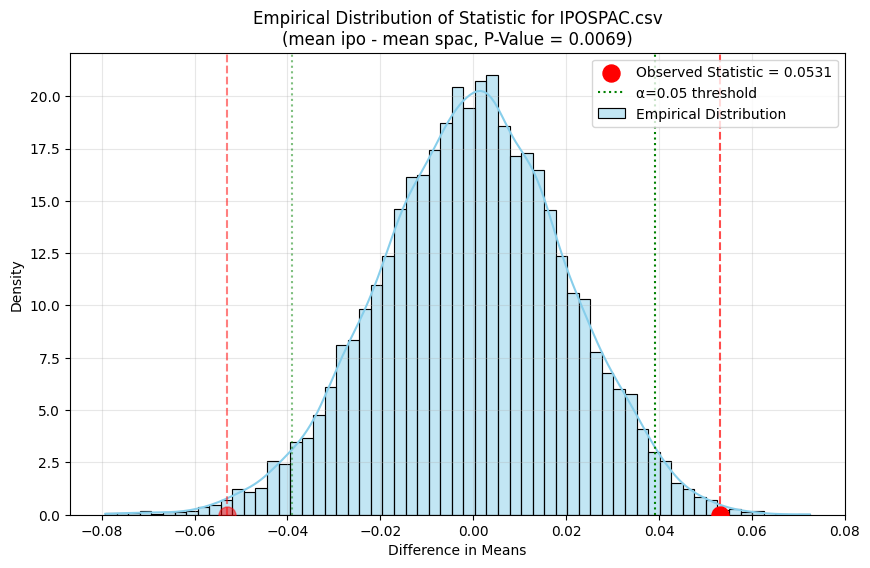

IPOSPAC.csv: P-Value = 0.0069


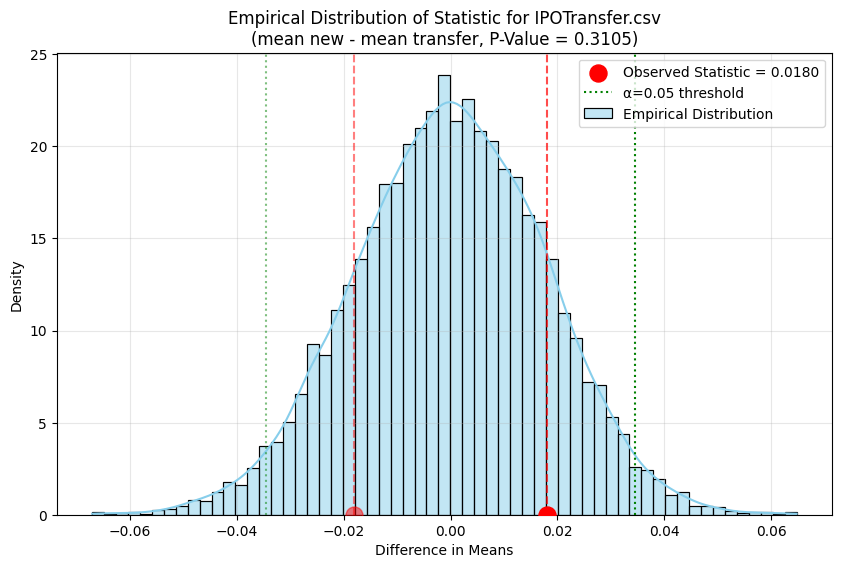

IPOTransfer.csv: P-Value = 0.3105


In [15]:
def plot_distribution_and_pvalue(empirical_stats, obs_stat, dataset_name, larger_group, smaller_group):
    plt.figure(figsize=(10, 6))
    # 히스토그램과 KDE
    sns.histplot(empirical_stats, kde=True, stat='density', label='Empirical Distribution', color='skyblue')
    
    # 관측 통계치(0.0531, 0.0180)에 점 표시
    plt.scatter([obs_stat], [0], color='red', s=150, zorder=5, label=f'Observed Statistic = {obs_stat:.4f}')
    plt.scatter([-obs_stat], [0], color='red', s=150, zorder=5, alpha=0.5)  # 양측 검정용
    
    # 점선으로 위치 보조 표시
    plt.axvline(obs_stat, color='red', linestyle='--', alpha=0.7)
    plt.axvline(-obs_stat, color='red', linestyle='--', alpha=0.5)
    
    # 유의수준 α=0.05 임계값
    alpha_threshold = np.percentile(np.abs(empirical_stats), 95)
    plt.axvline(alpha_threshold, color='green', linestyle=':', label=f'α=0.05 threshold')
    plt.axvline(-alpha_threshold, color='green', linestyle=':', alpha=0.5)
    
    # P-Value 계산
    p_value = np.mean(np.abs(empirical_stats) >= np.abs(obs_stat))
    
    # 그래프 설정
    plt.title(f'Empirical Distribution of Statistic for {dataset_name}\n(mean {larger_group} - mean {smaller_group}, P-Value = {p_value:.4f})')
    plt.xlabel('Difference in Means')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"{dataset_name}: P-Value = {p_value:.4f}")
    return p_value

# P-Value 및 그래프 - IPOSPAC.csv
p_value_ipospac = plot_distribution_and_pvalue(
    empirical_stats_ipospac, obs_stat_ipospac, 'IPOSPAC.csv', larger_ipospac, smaller_ipospac
)

# P-Value 및 그래프 - IPOTransfer.csv
p_value_ipotransfer = plot_distribution_and_pvalue(
    empirical_stats_ipotransfer, obs_stat_ipotransfer, 'IPOTransfer.csv', larger_ipotransfer, smaller_ipotransfer
)

## Step 6: P-Value 해석

p-값을 사용하여 귀무가설을 기각할지 여부를 결정한한다. 일반적인 임계값은 α = 0.05이다.

p-값 ≤ 0.05이면 H₀를 기각한다(차이가 우연에 의한 것일 가능성이 낮으므로 H₁을 지지).  
p-값 > 0.05이면 H₀를 기각하지 않는다(차이가 우연에 의한 것일 수 있음).

In [16]:
def interpret_p_value(p_value, dataset_name):
    alpha = 0.05
    print(f"\n{dataset_name} Interpretation:")
    if p_value <= alpha:
        print(f"P-Value ({p_value:.4f}) <= {alpha}: Reject Null Hypothesis.")
        print("The observed difference in means is unlikely due to chance.")
    else:
        print(f"P-Value ({p_value:.4f}) > {alpha}: Fail to Reject Null Hypothesis.")
        print("The observed difference in means could be due to chance.")

# Interpret - IPOSPAC.csv
interpret_p_value(p_value_ipospac, 'IPOSPAC.csv')

# Interpret - IPOTransfer.csv
interpret_p_value(p_value_ipotransfer, 'IPOTransfer.csv')


IPOSPAC.csv Interpretation:
P-Value (0.0069) <= 0.05: Reject Null Hypothesis.
The observed difference in means is unlikely due to chance.

IPOTransfer.csv Interpretation:
P-Value (0.3105) > 0.05: Fail to Reject Null Hypothesis.
The observed difference in means could be due to chance.
